<a href="https://colab.research.google.com/github/Saul-Ochoa/Classification-ML/blob/main/Jobs_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Jobs Predictions**

## **Analisis**

In [42]:
import pandas as pd
import shap
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
url='https://raw.githubusercontent.com/Saul-Ochoa/Python-MachineLearning/main/Classification/stackoverflow_full.csv'
df=pd.read_csv(url,sep=',')
df.head()

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


In [4]:
df.shape

(73462, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73462 entries, 0 to 73461
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      73462 non-null  int64  
 1   Age             73462 non-null  object 
 2   Accessibility   73462 non-null  object 
 3   EdLevel         73462 non-null  object 
 4   Employment      73462 non-null  int64  
 5   Gender          73462 non-null  object 
 6   MentalHealth    73462 non-null  object 
 7   MainBranch      73462 non-null  object 
 8   YearsCode       73462 non-null  int64  
 9   YearsCodePro    73462 non-null  int64  
 10  Country         73462 non-null  object 
 11  PreviousSalary  73462 non-null  float64
 12  HaveWorkedWith  73399 non-null  object 
 13  ComputerSkills  73462 non-null  int64  
 14  Employed        73462 non-null  int64  
dtypes: float64(1), int64(6), object(8)
memory usage: 8.4+ MB


In [6]:
df.isnull().sum()

Unnamed: 0         0
Age                0
Accessibility      0
EdLevel            0
Employment         0
Gender             0
MentalHealth       0
MainBranch         0
YearsCode          0
YearsCodePro       0
Country            0
PreviousSalary     0
HaveWorkedWith    63
ComputerSkills     0
Employed           0
dtype: int64

In [7]:
cat=df.select_dtypes(include='object').columns
df[cat]

,Age,Accessibility,EdLevel,Gender,MentalHealth,MainBranch,Country,HaveWorkedWith
0,<35,No,Master,Man,No,Dev,Sweden,C++;Python;Git;PostgreSQL
1,<35,No,Undergraduate,Man,No,Dev,Spain,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...
2,<35,No,Master,Man,No,Dev,Germany,C;C++;Java;Perl;Ruby;Git;Ruby on Rails
3,<35,No,Undergraduate,Man,No,Dev,Canada,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...
4,>35,No,PhD,Man,No,NotDev,Singapore,C++;Python
...,...,...,...,...,...,...,...,...
73457,<35,No,Undergraduate,Man,No,Dev,Germany,C#;HTML/CSS;JavaScript;TypeScript;Docker;Kuber...
73458,>35,No,Undergraduate,Man,No,Dev,United States of America,C#;HTML/CSS;Java;JavaScript;npm;ASP.NET Core ;...
73459,<35,No,Undergraduate,Man,No,Dev,Nigeria,HTML/CSS;JavaScript;TypeScript;Docker;Express;...
73460,<35,Yes,Undergraduate,Man,Yes,Dev,United States of America,C#;HTML/CSS;JavaScript;SQL;TypeScript;npm;Yarn...


In [8]:
describe_cat=df[cat].describe(include='object')
describe_cat.T.style.background_gradient(cmap='viridis',low=0.2,high=0.1)

,count,unique,top,freq
Age,73462,2,<35,47819
Accessibility,73462,2,No,71355
EdLevel,73462,5,Undergraduate,37402
Gender,73462,3,Man,68573
MentalHealth,73462,2,No,56944
MainBranch,73462,2,Dev,67396
Country,73462,172,United States of America,14696
HaveWorkedWith,73399,69980,Python,71


In [9]:
cat_col=['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth','MainBranch']
df[cat_col].head()

,Age,Accessibility,EdLevel,Gender,MentalHealth,MainBranch
0,<35,No,Master,Man,No,Dev
1,<35,No,Undergraduate,Man,No,Dev
2,<35,No,Master,Man,No,Dev
3,<35,No,Undergraduate,Man,No,Dev
4,>35,No,PhD,Man,No,NotDev


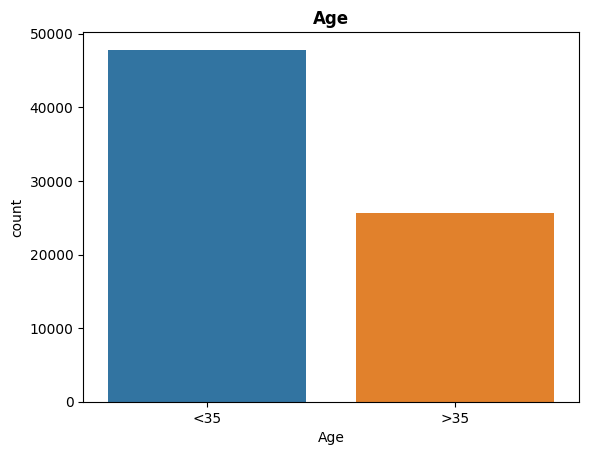

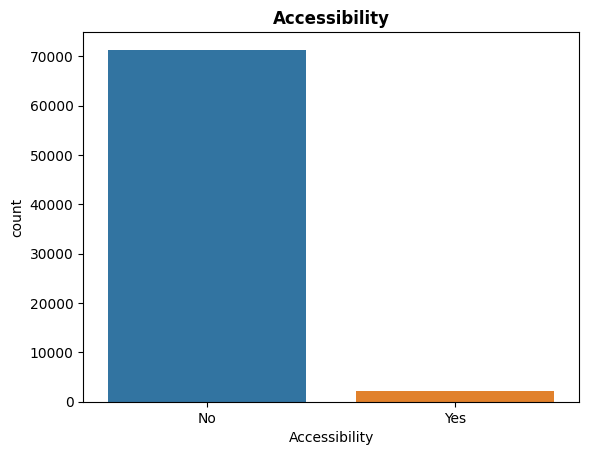

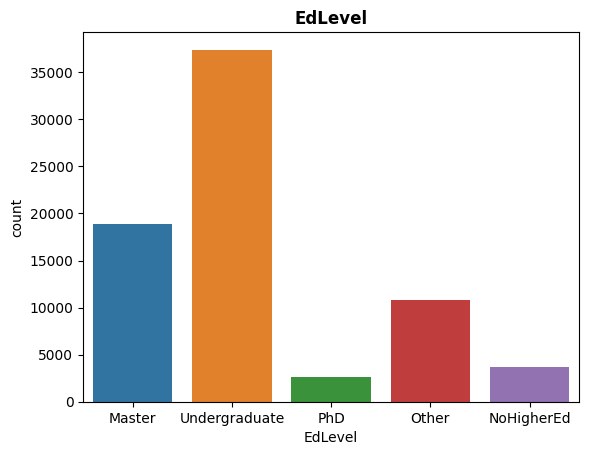

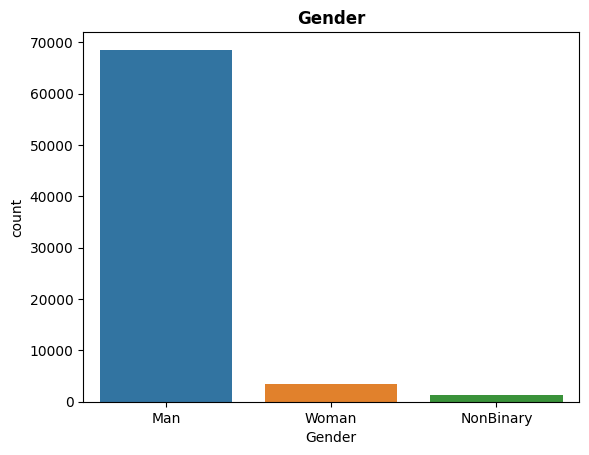

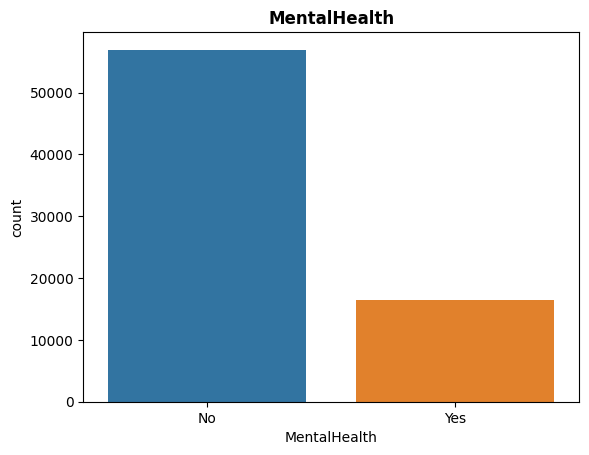

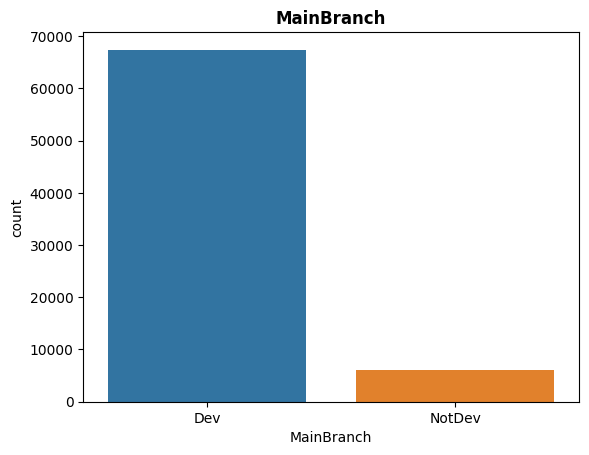

In [10]:
for i in cat_col:
  sns.countplot(data=df[cat_col].iloc[:,:6],x=i)
  plt.title(i,fontsize=12,weight='bold')
  plt.show()

In [11]:
# It looks from country salary distribition like the salary is measured in USD/year
df_country=df.groupby('Country')['PreviousSalary'].agg(lambda x: round(np.mean(x))).sort_values(ascending=False).head(30)
df_country=pd.DataFrame(df_country)
df_country.head()

,PreviousSalary
Country,
United States of America,123776
Israel,114151
Switzerland,105380
Andorra,90379
Denmark,90197


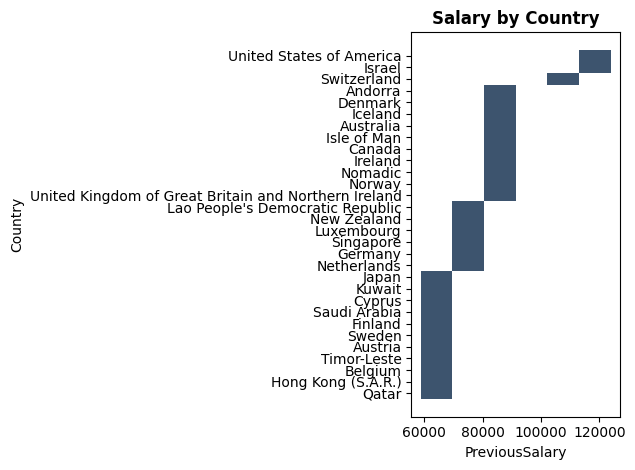

In [12]:
sns.histplot(data=df_country,y='Country',x='PreviousSalary')
plt.title('Salary by Country',fontsize=12,weight='bold')
plt.tight_layout()
plt.show()

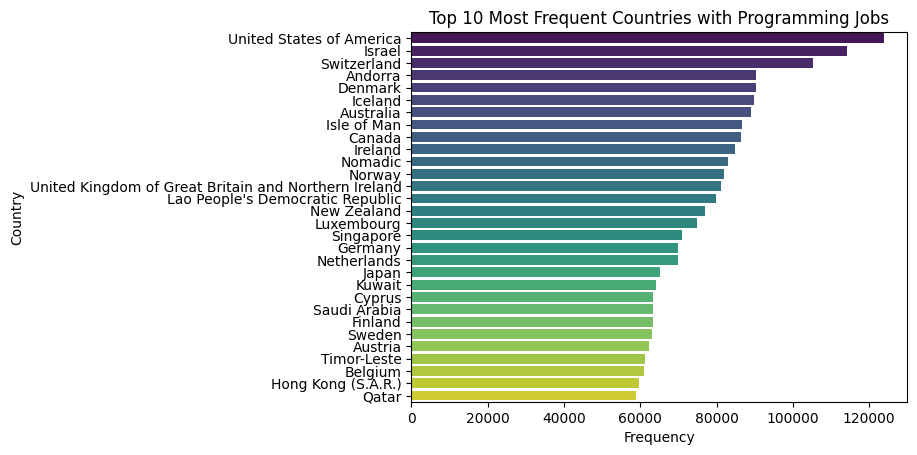

In [13]:
sns.barplot(x=df_country['PreviousSalary'], y=df_country.index, palette="viridis")
plt.xlabel('Frequency')
plt.ylabel('Country')
plt.title('Top 10 Most Frequent Countries with Programming Jobs')
plt.show()

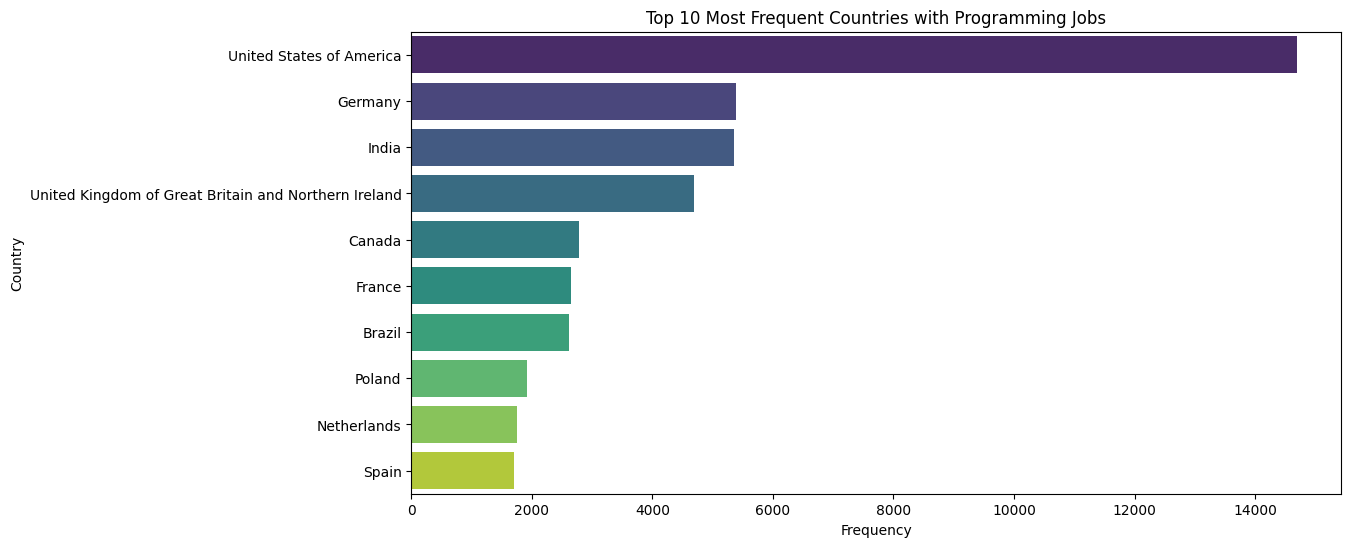

In [14]:
# Get the top 10 most frequent countries
top_countries = df['Country'].value_counts().nlargest(10)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")

plt.xlabel('Frequency')
plt.ylabel('Country')
plt.title('Top 10 Most Frequent Countries with Programming Jobs')
plt.show()

In [15]:
label_encoder=LabelEncoder()
df['Employed']=label_encoder.fit_transform(df['Employed'])
df['Employment']=label_encoder.fit_transform(df['Employment'])

In [16]:
df.head()

,Unnamed: 0,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


In [17]:
df.drop(columns='Unnamed: 0',inplace=True,axis=1)
num=df.select_dtypes(include='number').columns
df[num]

,Employment,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed
0,1,7,4,51552.0,4,0
1,1,12,5,46482.0,12,1
2,1,15,6,77290.0,7,0
3,1,9,6,46135.0,13,0
4,0,40,30,160932.0,2,0
...,...,...,...,...,...,...
73457,1,7,2,41058.0,13,1
73458,1,21,16,115000.0,11,1
73459,1,4,3,57720.0,12,1
73460,1,5,1,70000.0,15,1


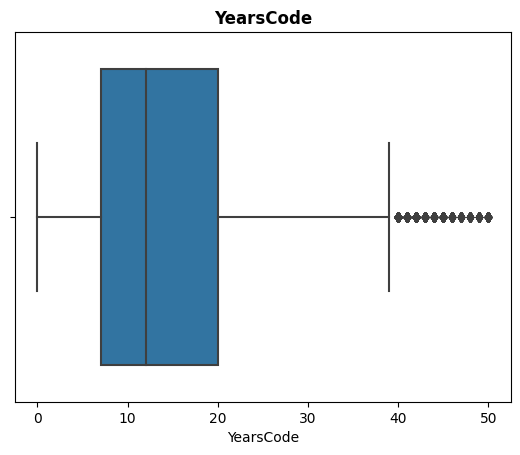

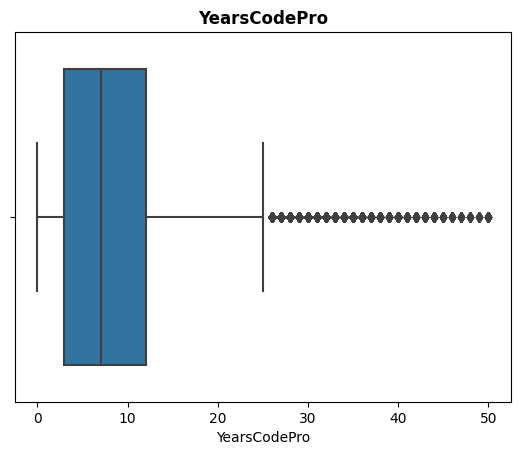

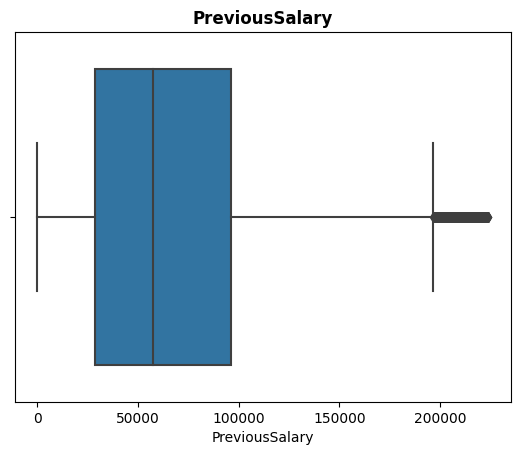

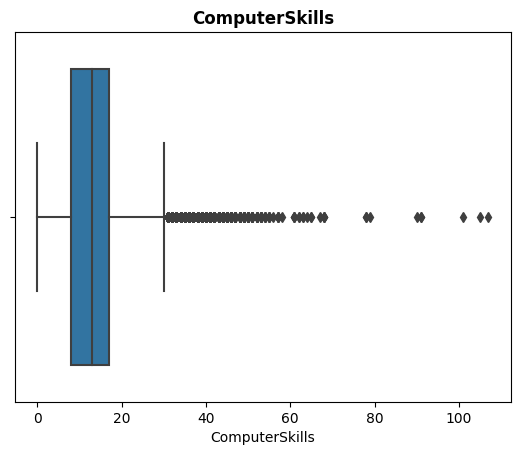

In [18]:
num=['YearsCode', 'YearsCodePro', 'PreviousSalary','ComputerSkills']
for i in num:
  sns.boxplot(data=df,x=i)
  plt.title(i,fontsize=12,weight='bold')
  plt.show()

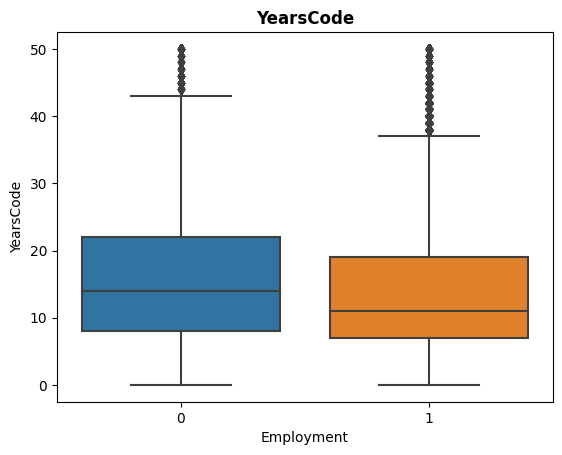

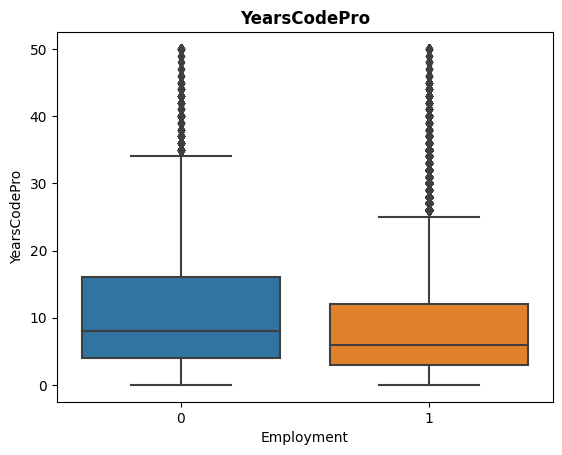

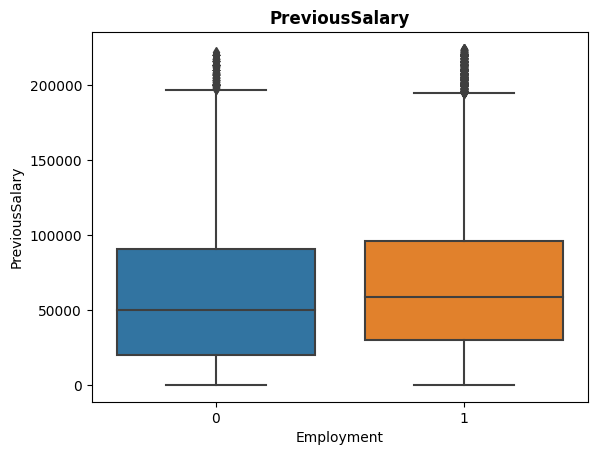

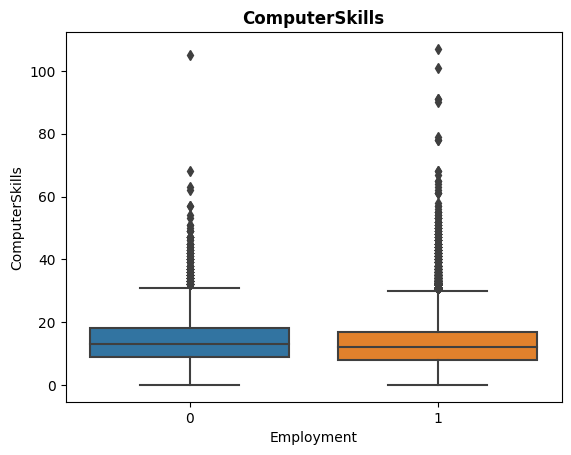

In [19]:
for i in num:
  sns.boxplot(data=df,y=i,x='Employment')
  plt.title(i,fontsize=12,weight='bold')
  plt.show()

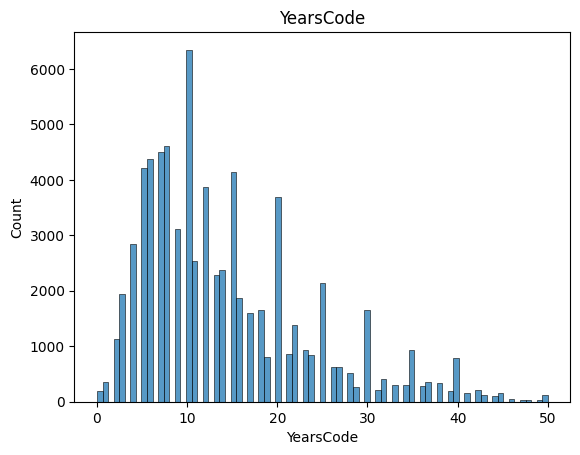

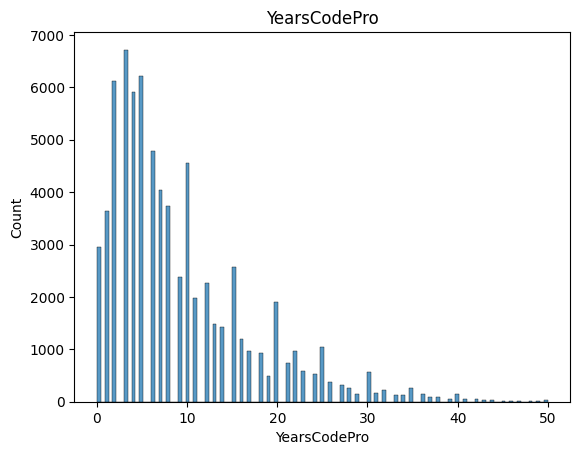

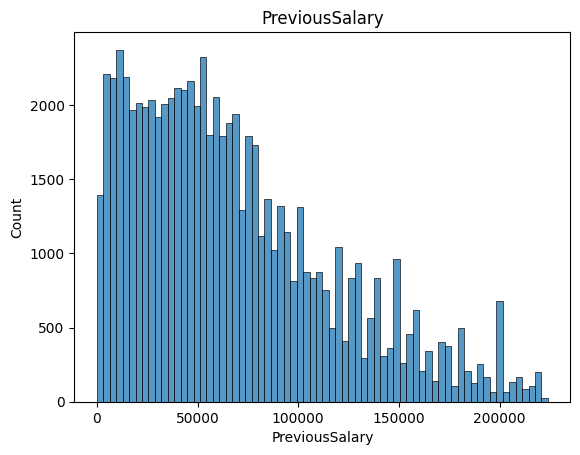

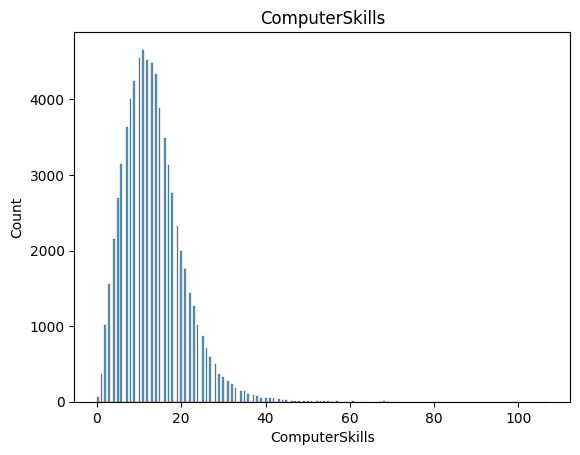

In [20]:
for i in num:
  sns.histplot(data=df,x=i)
  plt.title(i)
  plt.show()

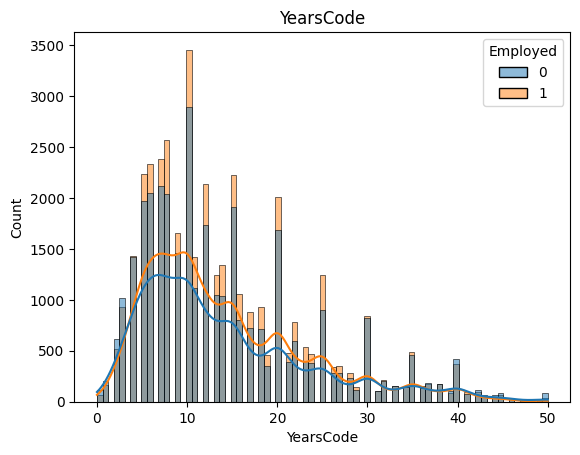

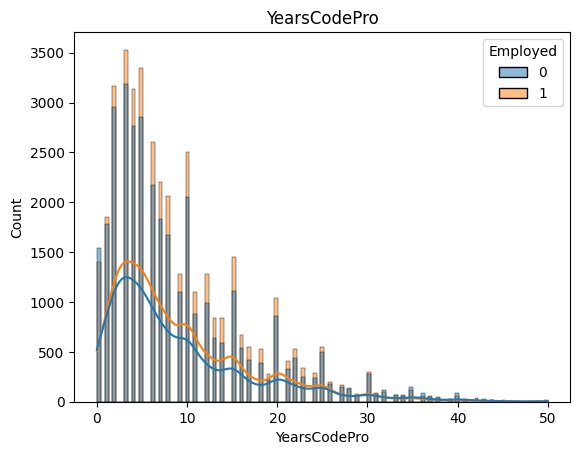

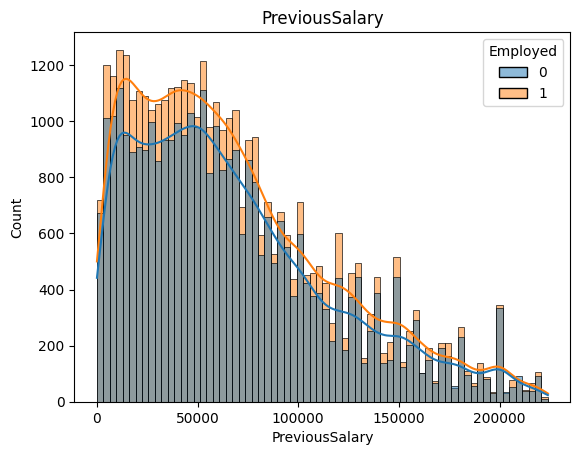

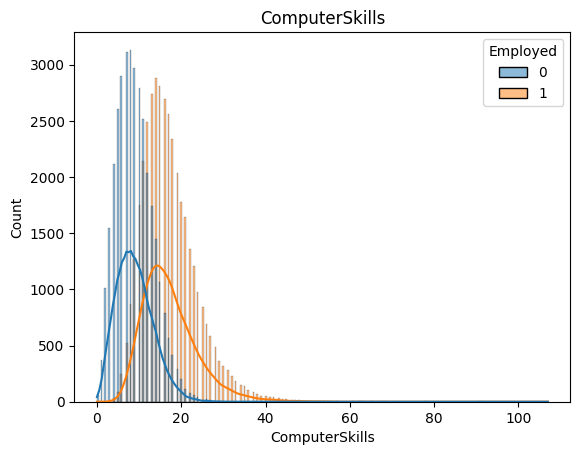

In [21]:
for i in num:
  sns.histplot(data=df,x=i,hue='Employed', kde=True)
  plt.title(i)
  plt.show()

## **Data Preprocessing**

In [22]:
df.drop(columns='Country',axis=1,inplace=True)
df.drop(columns='HaveWorkedWith',axis=1,inplace=True)
df.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,PreviousSalary,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,51552.0,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,46482.0,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,77290.0,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,46135.0,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,160932.0,2,0


In [23]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:

    # Print the column name and the unique values
    print(f"{col}: {df[col].unique()}")

Age: ['<35' '>35']
Accessibility: ['No' 'Yes']
EdLevel: ['Master' 'Undergraduate' 'PhD' 'Other' 'NoHigherEd']
Gender: ['Man' 'Woman' 'NonBinary']
MentalHealth: ['No' 'Yes']
MainBranch: ['Dev' 'NotDev']


In [24]:
# Aplicar el LabelEncoder a las columnas 'Employment' y 'Employed'
df['Age'] = label_encoder.fit_transform(df['Age'])
df['Accessibility'] = label_encoder.fit_transform(df['Accessibility'])
df['EdLevel'] = label_encoder.fit_transform(df['EdLevel'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['MentalHealth'] = label_encoder.fit_transform(df['MentalHealth'])
df['MainBranch'] = label_encoder.fit_transform(df['MainBranch'])

In [25]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['int']).columns:
  # Print the column name and the unique values
  print(f"{col}: {df[col].unique()}")

Age: [0 1]
Accessibility: [0 1]
EdLevel: [0 4 3 2 1]
Employment: [1 0]
Gender: [0 2 1]
MentalHealth: [0 1]
MainBranch: [0 1]
YearsCode: [ 7 12 15  9 40 26 14 39 20  4  6 19  8 22 34 21  5 25 24 10 31 18 38 13
  3 17 27  1 30  2 41 42 16 35 23 28 37 44 11 36 45 50 33 43 29 32 47 48
  0 46 49]
YearsCodePro: [ 4  5  6 30  2 18 21 16 10  0  3 15  1 12  8  7 17 14 26 25 34 11 24 22
 13  9 20 31 23 39 27 19 35 33 50 37 43 40 29 38 32 42 28 36 44 47 45 41
 49 48 46]
ComputerSkills: [  4  12   7  13   2   5  17   3   6  18  16  25  14  39   8  24  21  10
  11  33  26  19  23  20  28  22  15   1   9  32  29  30  36  27  53  43
  31  40   0  41  38  44  35  42  34  37  78  51  47  63  50  49  62  48
  52  54  45  55  46  68  91  61  57  90  58  65 105  67  56  79  64 101
 107]
Employed: [0 1]


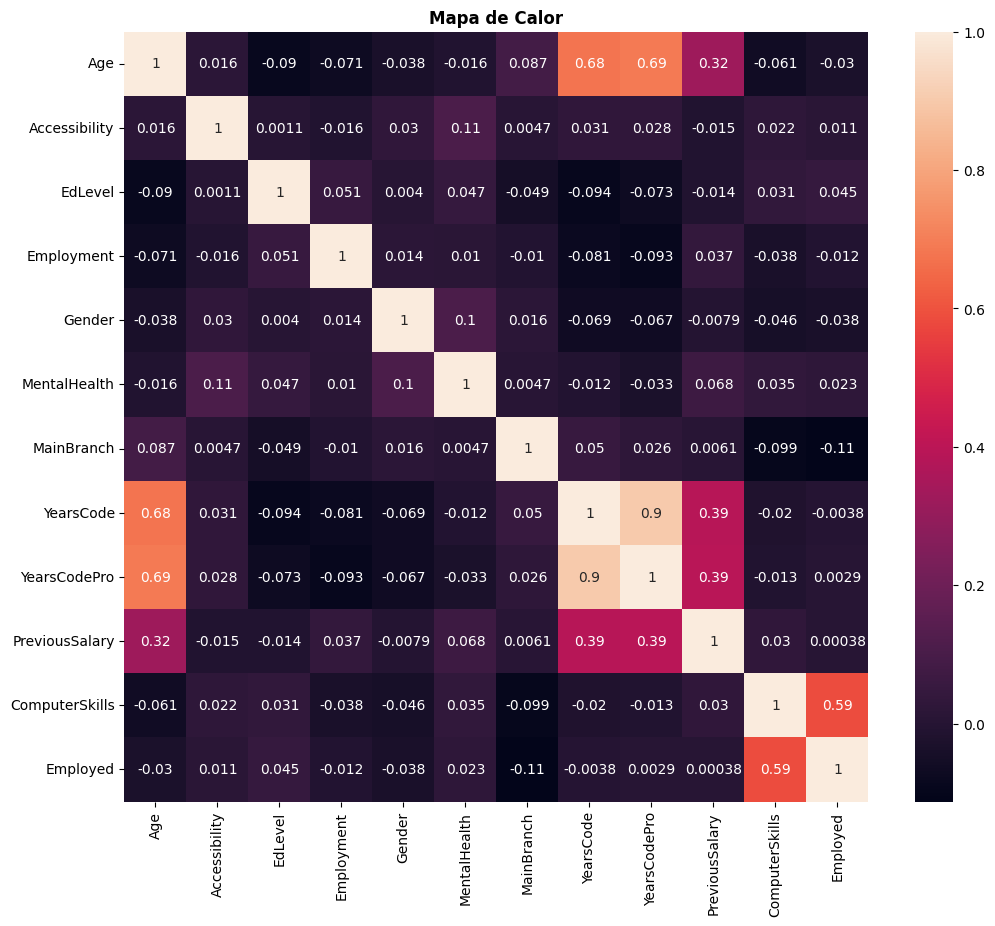

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), fmt='.2g', annot=True)
plt.title('Mapa de Calor',fontsize=12,weight='bold')
plt.show()

In [27]:
df.drop(columns='YearsCodePro',inplace=True)
df.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,PreviousSalary,ComputerSkills,Employed
0,0,0,0,1,0,0,0,7,51552.0,4,0
1,0,0,4,1,0,0,0,12,46482.0,12,1
2,0,0,0,1,0,0,0,15,77290.0,7,0
3,0,0,4,1,0,0,0,9,46135.0,13,0
4,1,0,3,0,0,0,1,40,160932.0,2,0


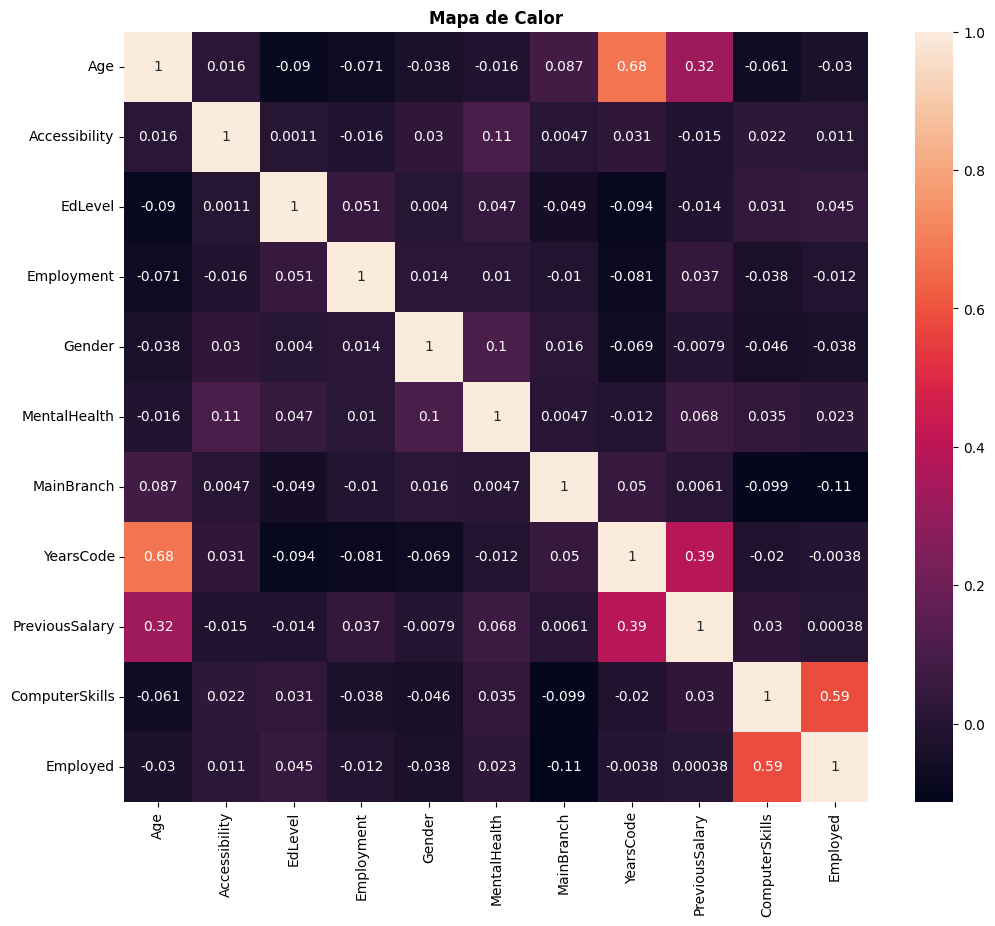

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), fmt='.2g', annot=True)
plt.title('Mapa de Calor',fontsize=12,weight='bold')
plt.show()

## **Train Test Split**

In [29]:
X = df.drop('Employed', axis=1)
y = df['Employed']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [31]:
# Remove outliers
from scipy import stats
cols=['YearsCode', 'PreviousSalary', 'ComputerSkills']
z_scores=np.abs(stats.zscore(X_train[cols]))
threshold=3
outlier_indices=np.where(z_scores>threshold)[0]
X_train=X_train.drop(X_train.index[outlier_indices])
y_train=y_train.drop(y_train.index[outlier_indices])

## **Decision TreeClassifier**

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
tree=DecisionTreeClassifier(class_weight='balanced')
param_grid={
    'max_depth': [3, 4, 5, 6, 7, 8,10,12,15,17,20],
    'min_samples_split': [2, 3, 4,5,6,7,8,9],
    'min_samples_leaf': [1, 2, 3, 4,5,6,7,8],
    'random_state': [0,25,50,100,120],
    'criterion':['gini','entropy','log_loss']
}

grid_search=GridSearchCV(tree,param_grid,cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}


In [51]:
tree = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, class_weight='balanced',criterion='gini')
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=0)

In [52]:
y_pred = tree.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 78.11 %


In [53]:
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.7811202613489416
Precision Score :  0.7811202613489416
Recall Score :  0.7811202613489416
Jaccard Score :  0.6408509687866436
Log Loss :  7.889225433839295


Text(0.5, 1.0, 'Accuracy Score for Decision Tree: 0.7811202613489416')

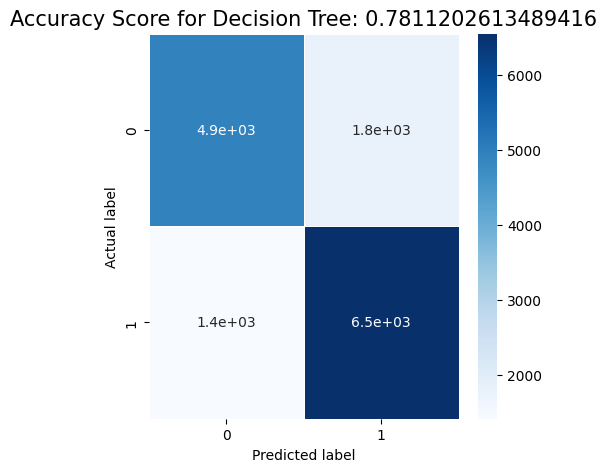

In [54]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Decision Tree: {0}'.format(tree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

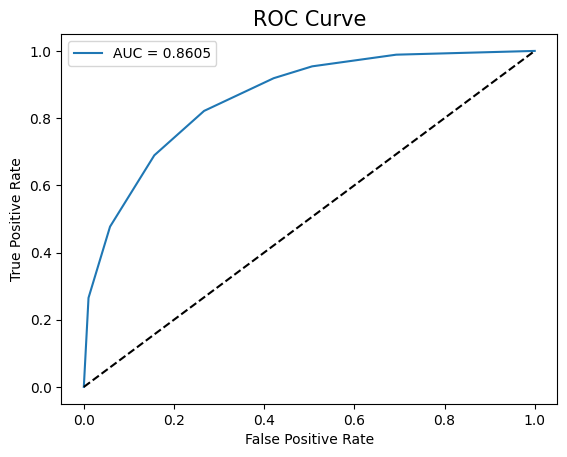

In [56]:
y_pred_proba = tree.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

## **Random Forest Classifier**

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(class_weight='balanced')
param_grid={
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [0, 42],
    'criterion':['gini','entropy','log_loss'],
    'n_jobs':[-1,1]
}
# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}


In [33]:
rfc = RandomForestClassifier(random_state=42, max_depth=10, max_features='sqrt', n_estimators=200, n_jobs=-1,class_weight='balanced', criterion='gini')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [34]:
y_pred = rfc.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

Accuracy Score : 78.06 %
F-1 Score :  0.7805757843871232
Precision Score :  0.7805757843871232
Recall Score :  0.7805757843871232
Jaccard Score :  0.6401183233800302
Log Loss :  7.908850372729443


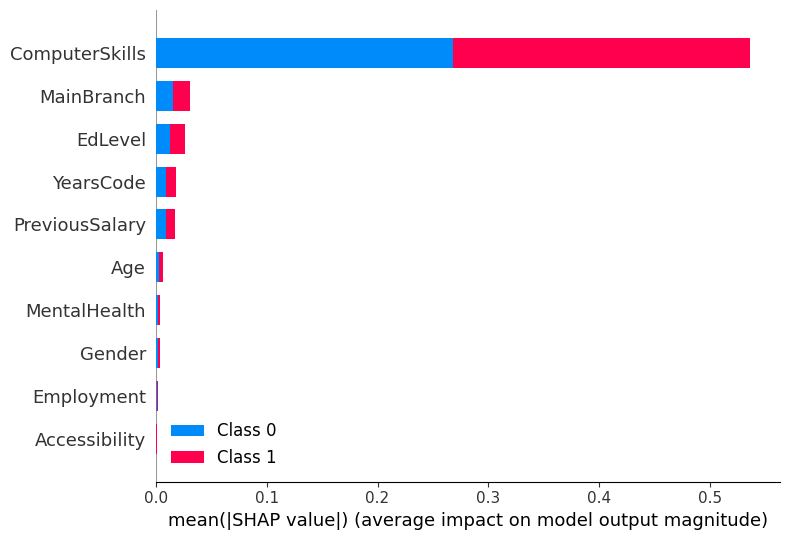

In [37]:
import shap
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Text(0.5, 1.0, 'Accuracy Score for Random Forest: 0.7805757843871232')

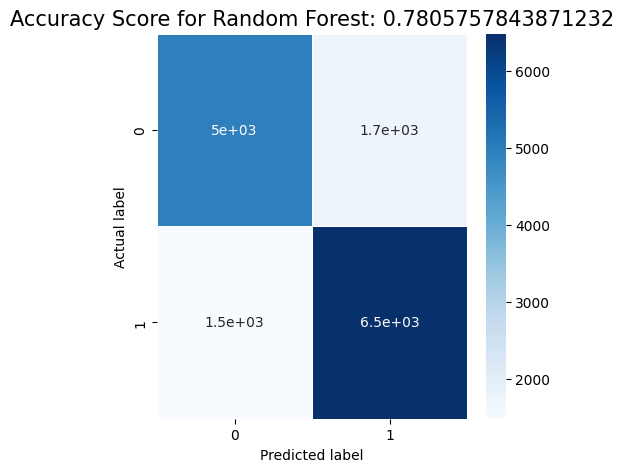

In [38]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for Random Forest: {0}'.format(rfc.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

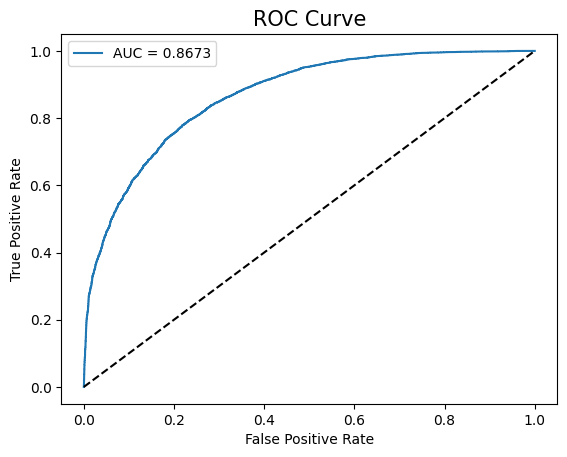

In [40]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]
df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=['y_actual']), pd.DataFrame(y_pred_proba, columns=['y_pred_proba'])], axis=1)
df_actual_predicted.index = y_test.index

fpr, tpr, tr = roc_curve(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])
auc = roc_auc_score(df_actual_predicted['y_actual'], df_actual_predicted['y_pred_proba'])

plt.plot(fpr, tpr, label='AUC = %0.4f' %auc)
plt.plot(fpr, fpr, linestyle = '--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', size = 15)
plt.legend()

## **XGBOOST-CLASSIFIER**

In [35]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'objective':['binary:logistic'],
    'n_estimators': [10,50,100,150,200]

}

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'objective': 'binary:logistic', 'subsample': 0.8}


In [37]:
xgb_classifier = xgb.XGBClassifier(colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, subsample=0.8,objective='binary:logistic',n_estimators= 50)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
y_pred = xgb_classifier.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

Accuracy Score : 78.32 %
F-1 Score :  0.7832301095759885
Precision Score :  0.7832301095759886
Recall Score :  0.7832301095759886
Jaccard Score :  0.6436961628817541
Log Loss :  7.813178795639974


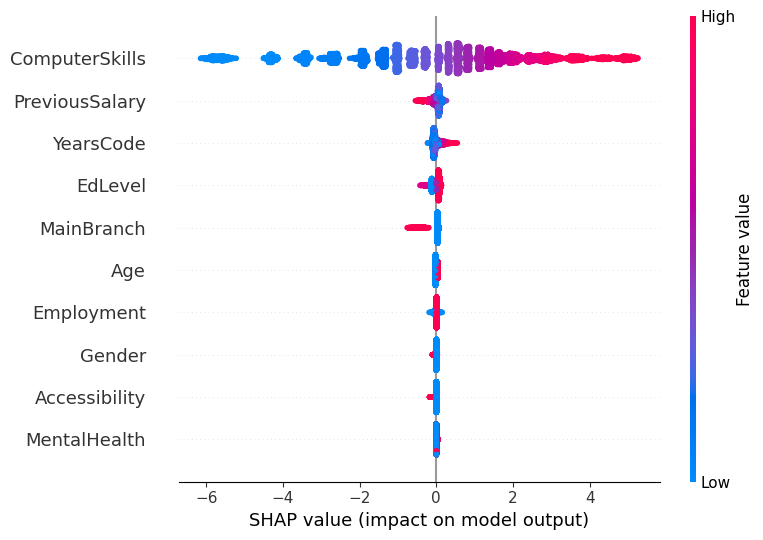

In [43]:
explainer = shap.TreeExplainer(xgb_classifier)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

Text(0.5, 1.0, 'Accuracy Score for XGBoost: 0.7832301095759886')

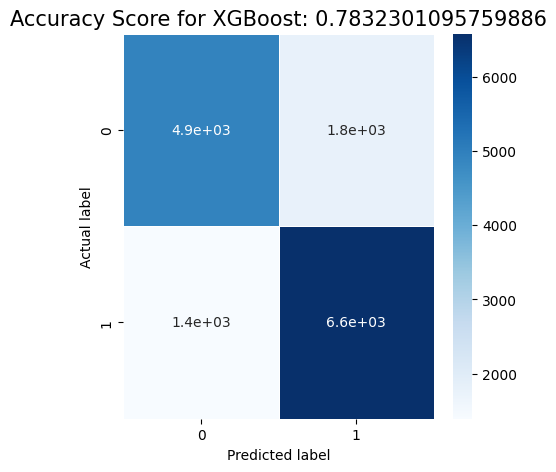

In [44]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score for XGBoost: {0}'.format(xgb_classifier.score(X_test, y_test))
plt.title(all_sample_title, size = 15)